In [2]:
library(ggplot2)
library(cowplot)
library(RColorBrewer)


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [3]:
sce = readRDS("/hps/nobackup2/stegle/users/acuomo/endodiff_sce.rds")

In [5]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC
altExpNames(0):

In [6]:
# names(colData(sce))

In [7]:
revision_folder = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/"

In [8]:
crm_int_file = paste0(revision_folder, "CRM_interaction_chr22/results_permG/summary.csv")
crm_int = read.csv(crm_int_file, row.names=1)
nrow(crm_int)
head(crm_int,2)

[1] 542

,gene,n_snps,chrom,pv_raw,snpID
0,ENSG00000100028,2,22,0.8564981,22_24852233_T_A
1,ENSG00000100028,2,22,0.8014707,22_24853465_G_A


In [9]:
genes = as.character(unique(crm_int$gene))

In [11]:
for (gene in genes){
    gene_name = rownames(sce)[grep(gene, rownames(sce))]
    name = gsub(".*_","",gene_name)
    df = data.frame(pseudo = sce$pseudo, gene = logcounts(sce)[gene_name,])
    r = cor(df$pseudo, df$gene)
    crm_int[crm_int$gene == gene,"r"] = r
}

In [12]:
head(crm_int,2)

,gene,n_snps,chrom,pv_raw,snpID,r
0,ENSG00000100028,2,22,0.8564981,22_24852233_T_A,-0.2385039
1,ENSG00000100028,2,22,0.8014707,22_24853465_G_A,-0.2385039


In [13]:
cor(crm_int$r, -log10(crm_int$pv_raw))

[1] 0.0338426

In [14]:
corr_genes = unique(crm_int[abs(crm_int$r)>0.2,"gene"])

In [15]:
noncorr_genes = unique(crm_int[abs(crm_int$r)<0.1,"gene"])

In [16]:
df0 = crm_int[crm_int$gene %in% corr_genes, ]

In [17]:
df1 = crm_int[crm_int$gene %in% noncorr_genes, ]

In [24]:
df0$pv_uniform = runif(dim(df0)[1], min = 0, max = 1)
p0 = ggplot(df0, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(pv_raw)))) + 
    geom_abline(slope = 1, intercept = 0, col = "firebrick") +
    geom_point(alpha = 0.8, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
    theme_classic() +# xlim(c(0,4)) + ylim(c(0,4)) +
    theme(legend.position="none", panel.border = element_blank()) + ggtitle("|R|>0.2")

In [25]:
df1$pv_uniform = runif(dim(df1)[1], min = 0, max = 1)
p1 = ggplot(df1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(pv_raw)))) + 
    geom_abline(slope = 1, intercept = 0, col = "firebrick") +
    geom_point(alpha = 0.8, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
    theme_classic() +# xlim(c(0,4)) + ylim(c(0,4)) +
    theme(legend.position="none", panel.border = element_blank()) + ggtitle("|R|<0.1")

In [26]:
median(df0$pv_uniform)
median(df1$pv_uniform)

[1] 0.4892878

[1] 0.5228345

In [27]:
nrow(df0)
nrow(df1)

[1] 134

[1] 218

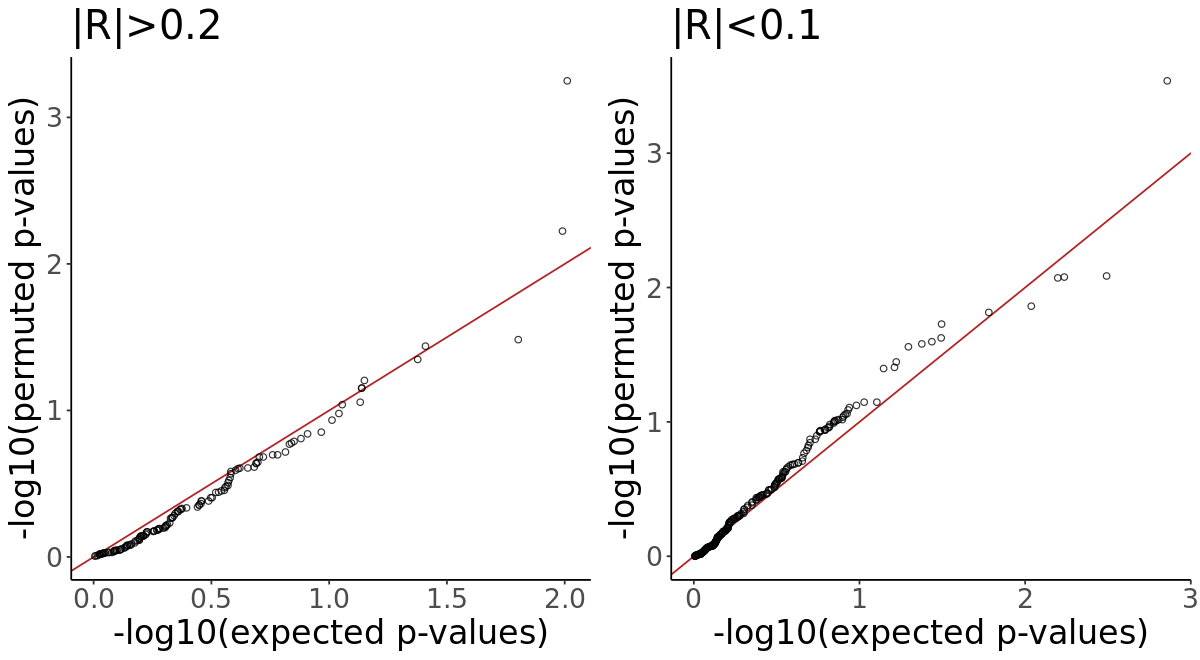

In [30]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot_grid(p0 + theme(text = element_text(size=20)),
          p1+ theme(text = element_text(size=20)),
          ncol=2)

In [31]:
fig_dir = "/hps/nobackup2/stegle/users/acuomo/CellRegMap_data/figures/"
pdf(paste0(fig_dir,"SF7C_endodiff.pdf"), width=10, height=5.5)
plot_grid(p0 + theme(text = element_text(size=20)),
          p1+ theme(text = element_text(size=20)),
          ncol=2)
dev.off()

png 
  2